In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
plt.rcParams["figure.figsize"] = [12.0, 8.0]
plt.rcParams["font.size"] = 20

# Linear Regression Class with Stochastic Mini-Batch Gradient Descent

To match the neural network convention more closely, I am keeping a separate weight and bias

In [4]:
class Batch:
    
    def __init__(self, data):
        self.X = data[:, :-1]
        self.Y = data[:, -1]

class LinearRegression:
    
    def __init__(self, data, l1_lambda=0, l2_lambda=0, learning_rate=0.01, batch_size=10, num_epochs=100):
        self.data, self.l1_lambda, self.l2_lambda = data, l1_lambda, l2_lambda
        self.learning_rate, self.batch_size, self.num_epochs = learning_rate, batch_size, num_epochs
        self.weight = np.random.randn(self.data.X.shape[1])
        self.bias = np.random.randn()
        self.epoch = 0
    
    def start_epoch(self):
        self.data_copy = np.hstack((self.data.X[:], self.data.Y.reshape(len(self.data.Y), 1)[:]))
        np.random.shuffle(self.data_copy)
    
    def get_batch(self):
        if len(self.data_copy) > self.batch_size:
            data = self.data_copy[-self.batch_size:]
            self.data_copy = self.data_copy[:-self.batch_size]
        else:
            data = self.data_copy
            self.epoch += 1
            self.start_epoch()
        return Batch(data)
    
    def dW(self, batch):
        yhat = self.bias + batch.X.dot(self.weight)
        grad = np.sum((yhat - batch.Y).reshape(len(batch.Y), 1)*batch.X, axis=0) / len(batch.Y)
        grad += self.l1_lambda * np.sign(self.weight)
        grad += self.l2_lambda * self.weight
        return grad
    
    def db(self, batch):
        yhat = self.bias + batch.X.dot(self.weight)
        grad = np.sum(yhat - batch.Y, axis=0) / len(batch.Y)
        return grad
    
    def loss(self, data):
        yhat = data.X.dot(self.weight) + self.bias
        return np.sum((yhat - data.Y) ** 2)/(2 * len(data.Y))
    
    def train_loss(self):
        return self.loss(self.data)
        
    def train(self, test_data=None):
        self.train_loss_curve = [self.train_loss()]
        if test_data:
            self.test_loss_curve = [self.loss(test_data)]
        self.start_epoch()
        while self.epoch < self.num_epochs:
            batch = self.get_batch()
            dW = self.dW(batch)
            db = self.db(batch)
            self.weight -= self.learning_rate * dW
            self.bias -= self.learning_rate * db
            self.train_loss_curve.append(self.train_loss())
            if test_data:
                self.test_loss_curve.append(self.loss(test_data))

## Logistic Regression

Since the gradient expression is the same for linear regression (with MSE loss) vs. logistic regression (with cross entropy loss), the only function we need to change for logistic regression is the 

In [5]:
class LogisticRegression(LinearRegression):
    
    def loss(self, data):
        p = data.X.dot(self.weight) + self.bias
        return -np.sum(data.Y * np.log(p) + (1 - data.Y) * np.log(1 - p))/len(data.Y)

# Data

I've copied this cell from Data_Generation_Notebook.ipynb to make this notebook more portable.  This class lets us generate uniform data in n_features dimensions with n_samples data points.  The x_i values are uniformly distributed between 0 and 1.  If not specified the weight vector (extended so that its zero component is the bias) has all of its components chosen from a Gaussian random distribution with zero mean and unit variance.  Zero mean, unit variance Gaussian noise is added to calculated y_values with an overall strength parameterized by noise_strength.

In [6]:
class LinearRegressionData:
    
    def __init__(self, n_features, n_samples, weight_vector=None, extend_weight_vector=True, noise_strength=0.01):
        """
        
        """
        self.n_features, self.n_samples, self.noise_strength = n_features, n_samples, noise_strength
        self.extend_weight_vector = extend_weight_vector
        self.generate_weight_vector(weight_vector)
        self.generate_data()
        self.Y_regression = None
                
    def generate_weight_vector(self, weight_vector):
        """
        
        """
        if weight_vector is None:
            dim = self.n_features + (1 if self.extend_weight_vector else 0) 
            self.weight_vector = np.random.randn(dim)
        else:
            self.weight_vector = weight_vector
        
    def generate_data(self):
        """
        Generate 
        """
        if self.extend_weight_vector:
            self.X = np.hstack((np.ones((self.n_samples, 1)), np.random.rand(self.n_samples, self.n_features)))
        else:
            self.X = np.random.rand(self.n_samples, self.n_features)
        self.Y = self.X.dot(self.weight_vector) + self.noise_strength * np.random.randn(self.n_samples)
        
    def binarize_labels(self):
        p = 1.0 / (1.0 + np.exp(-self.Y))
        self.Y_regression = self.Y
        self.Y = np.where(p > 0.5, np.ones(self.Y.shape), np.zeros(self.Y.shape))
        
    def continuous_labels(self):
        if self.Y_regression:
            self.Y = self.Y_regression

# Train/ Test Split

In [7]:
class Data:
    
    def __init__(self, data):
        self.X = data[:, :-1]
        self.Y = data[:, -1]
    

class TrainTestSplit:
    
    def __init__(self, data, train_frac):
        combined = np.hstack((data.X[:], data.Y.reshape(len(data.Y), 1)[:]))
        np.random.shuffle(combined)
        train_set_length = round(train_frac * len(combined))
        self.train = Data(combined[:train_set_length])
        self.test = Data(combined[train_set_length:])

# Example 1: Linear Regression

In [89]:
data = TrainTestSplit(
    LinearRegressionData(30, 300, extend_weight_vector=False, noise_strength=3.0),
    0.8)

In [90]:
fit = LinearRegression(data.train)
fit.train(test_data=data.test)

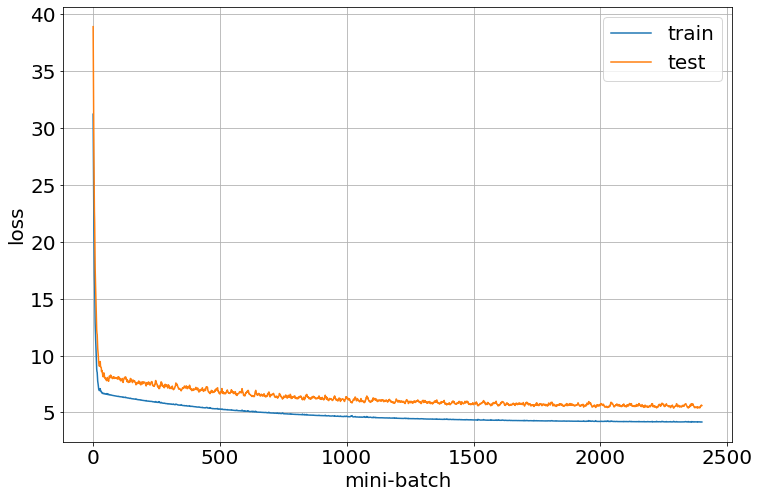

In [91]:
plt.plot(fit.train_loss_curve, label = 'train')
plt.plot(fit.test_loss_curve, label = 'test')
plt.grid()
plt.xlabel("mini-batch")
plt.ylabel("loss")
plt.legend()

# Example 2: Logistic Regression

In [92]:
d = LinearRegressionData(100, 500, extend_weight_vector=False, noise_strength=3.0) 
d.binarize_labels()
data = TrainTestSplit(d, 0.85)

In [93]:
fit = LinearRegression(data.train)
fit.train(test_data=data.test)

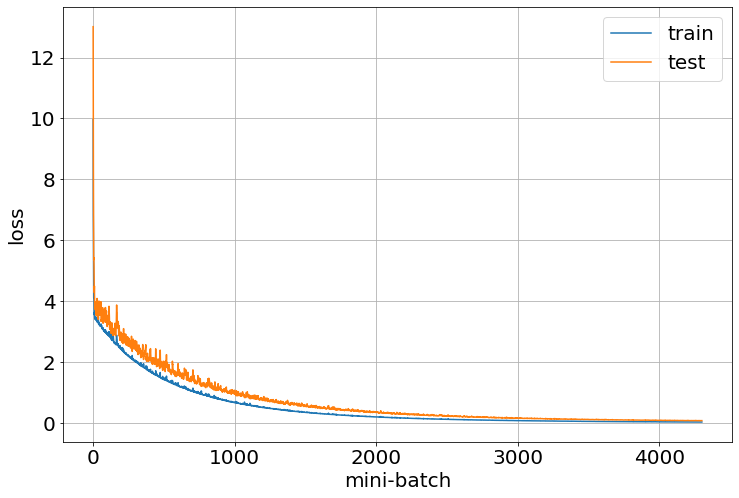

In [94]:
plt.plot(fit.train_loss_curve, label = 'train')
plt.plot(fit.test_loss_curve, label = 'test')
plt.grid()
plt.xlabel("mini-batch")
plt.ylabel("loss")
plt.legend()